# **CVAT XML to yoloOBB**

楕円アノテーション付きのCVAT XMLファイルから、
YOLOv11 OBB形式のラベルファイルを生成するスクリプト

In [12]:
# =============================================
# 楕円アノテーション付きのCVAT XMLファイルから、
# YOLOv11 OBB形式のラベルファイルを生成するスクリプト
#
# ■ 入力: CVAT形式のXMLファイル
# ■ 出力: YOLO OBB形式のテキストファイル（画像ごと）
# ■ 対象クラス: "Pupil", "Iris"
# ■ 出力形式: クラスID + 楕円から計算した4点 (正規化済み)
# ■ 回転角を含めて楕円を4点で近似
# =============================================
import os
import xml.etree.ElementTree as ET
import numpy as np
import math
import glob
import traceback

# ——— 設定 ———
XML_PATH     = r"eyelid_image/1-295_periocular/1-295cvat.xml"
OUTPUT_DIR   = r"C:\Users\CorneAI\YOLOv11_OBB\eyelid_image\1-295_periocular\labels"
CLASS_MAP    = {"Pupil": 0, "Iris": 1}
os.makedirs(OUTPUT_DIR, exist_ok=True)

def ellipse_to_bbox(cx, cy, rx, ry, angle_deg, img_w, img_h):
    """
    楕円の回転外接矩形４隅を計算し、正規化して返す。
    """
    φ = math.radians(angle_deg)
    cosφ, sinφ = math.cos(φ), math.sin(φ)
    # 主軸ベクトル (rx方向)
    ux, uy =  rx * cosφ,  rx * sinφ
    # 副軸ベクトル (ry方向)
    vx, vy = -ry * sinφ,  ry * cosφ

    corners = []
    for i, j in [(1,1), (1,-1), (-1,-1), (-1,1)]:
        x = cx + i*ux + j*vx
        y = cy + i*uy + j*vy
        x_n = np.clip(x / img_w, 0.0, 1.0)
        y_n = np.clip(y / img_h, 0.0, 1.0)
        corners.append((x_n, y_n))
    return corners

def process_xml_file(xml_file):
    print(f"Processing XML: {xml_file}")
    try:
        tree = ET.parse(xml_file)
        root = tree.getroot()
    except ET.ParseError as e:
        print(f"XML parse error: {e}")
        return 0, 1

    images = root.findall('.//image')
    success, errors = 0, 0

    for img in images:
        img_name = img.get('name')
        img_w = img.get('width')
        img_h = img.get('height')
        if not (img_name and img_w and img_h):
            errors += 1
            continue

        img_w, img_h = float(img_w), float(img_h)
        base, _ = os.path.splitext(img_name)
        out_file = os.path.join(OUTPUT_DIR, f"{base}.txt")

        annos = []
        for e in img.findall('ellipse'):
            label = e.get('label')
            if label not in CLASS_MAP:
                continue
            try:
                cx    = float(e.get('cx'))
                cy    = float(e.get('cy'))
                rx    = float(e.get('rx'))
                ry    = float(e.get('ry'))
                angle = float(e.get('rotation', 0.0))
            except (TypeError, ValueError):
                continue

            corners = ellipse_to_bbox(cx, cy, rx, ry, angle, img_w, img_h)
            # クラスID + 4点 (x1,y1,...,x4,y4)
            parts = [str(CLASS_MAP[label])]
            for x, y in corners:
                parts += [f"{x:.6f}", f"{y:.6f}"]
            annos.append(" ".join(parts))

        if annos:
            try:
                with open(out_file, 'w') as f:
                    f.write("\n".join(annos))
                success += 1
            except Exception as e:
                print(f"Write error for {out_file}: {e}")
                errors += 1
        else:
            # 注釈なし画像はスキップ
            continue

    return success, errors

def main():
    if not os.path.exists(XML_PATH):
        print(f"XML not found: {XML_PATH}")
        return

    s, e = process_xml_file(XML_PATH)
    print(f"\nFinished: Success={s}, Errors={e}")
    print(f"Labels saved in: {OUTPUT_DIR}")

if __name__ == "__main__":
    main()


Processing XML: eyelid_image/1-295_periocular/1-295cvat.xml

Finished: Success=494, Errors=0
Labels saved in: C:\Users\CorneAI\YOLOv11_OBB\eyelid_image\1-295_periocular\labels


Visualizing: 135-20170802-6-094251_8b5d78fd03abdeceec67622990cd73a16af3ded193670ce9f19c7c87d5252570_L


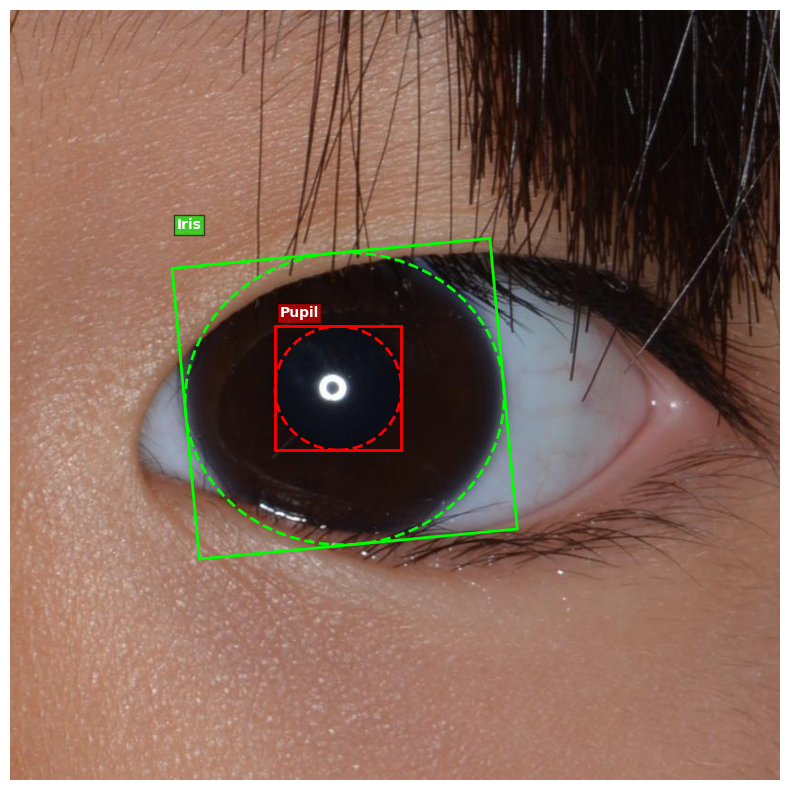

Visualizing: 129-20161026-73-104430_ceff10a39ec56a506590585e0d57e3b7e56985c00b22159a5be39d1f75f6c28d_L


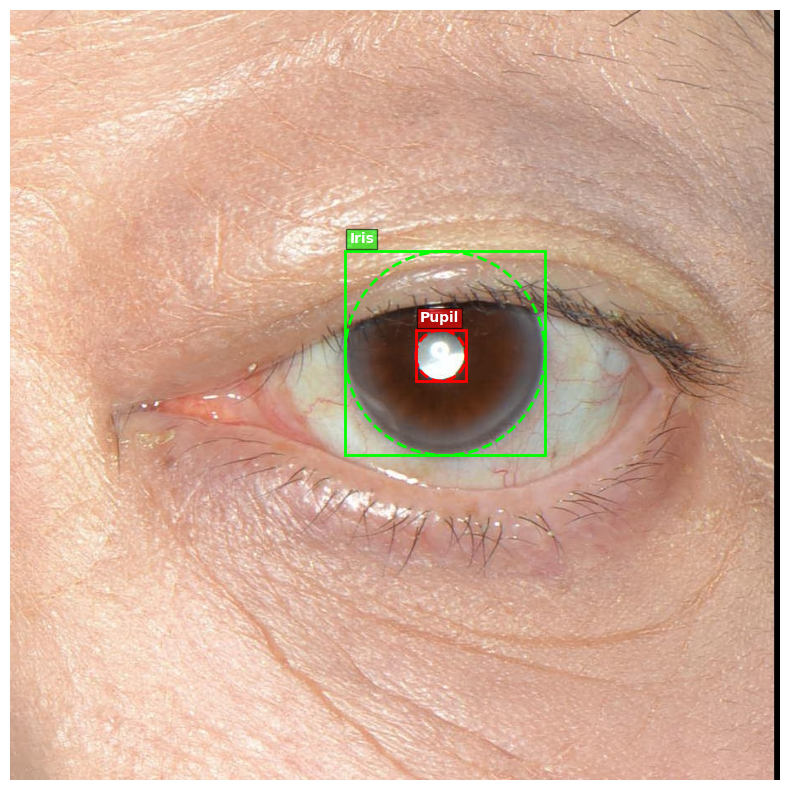

Visualizing: 136-20160804-11-135813_2ad70c40878189df38b739d8b42ede3abde4d3c7cc551bd1a1d0d5735caae406_L


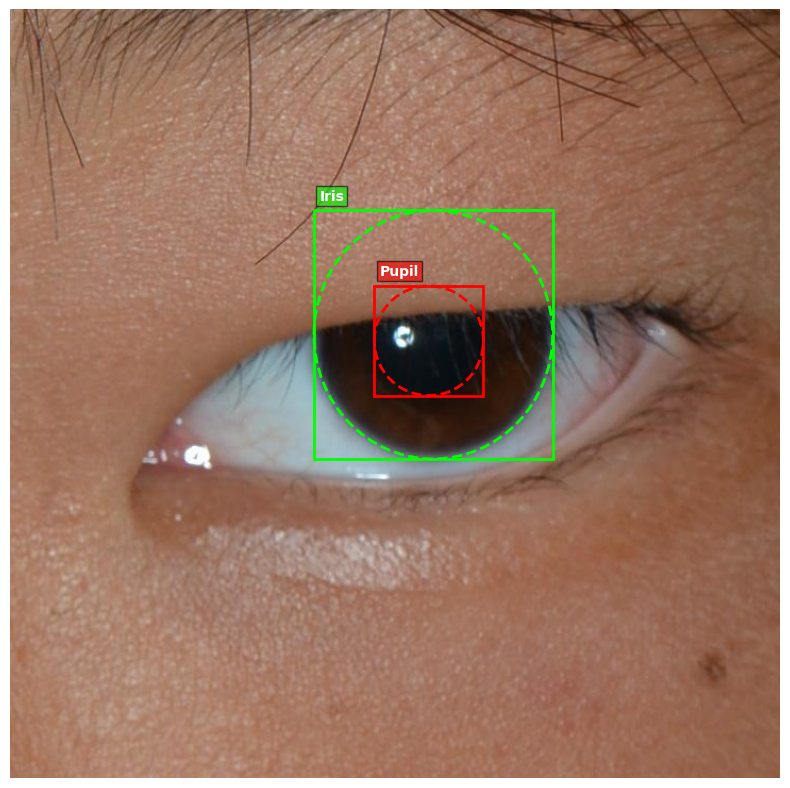

Visualizing: 136-20180919-14-112142_74ed623072ff25351ca2aefeeb4ace1c9b97b2aed3e3cd5772845e21e4b78547_R


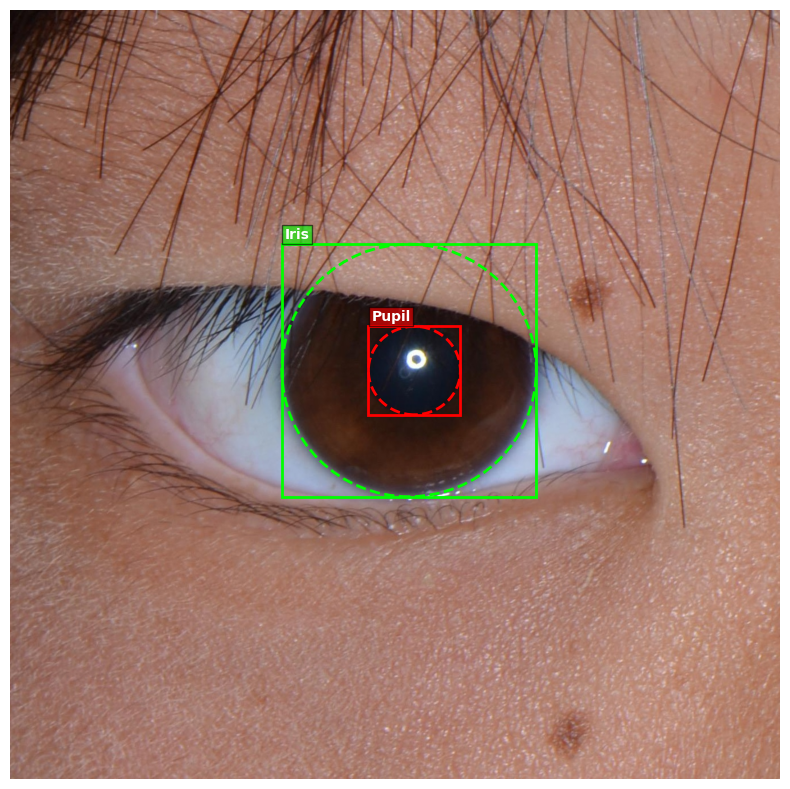

Visualizing: 137-20110909-18-000000_e1fb8bbf8223c4c4769ce16ff72328da5f3d21510bb00cf139dda3245b90d5ff_L


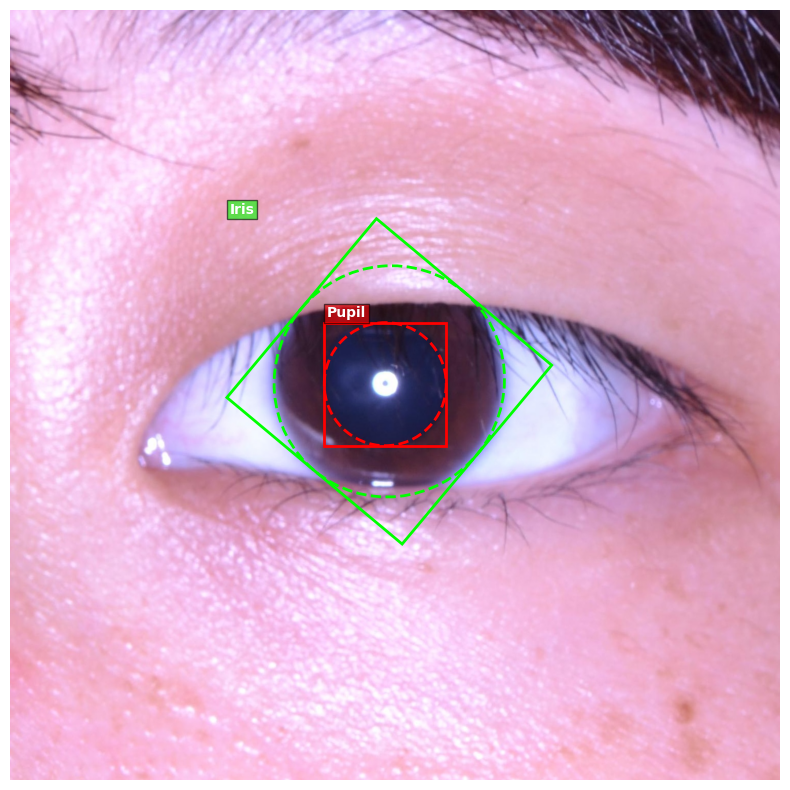

In [25]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import random
from matplotlib.patches import Polygon, Ellipse

# ——— 設定 ———
input_dir   = r"C:\Users\CorneAI\YOLOv11_OBB\eyelid_image\1-295_periocular"
images_dir  = os.path.join(input_dir, "images")
labels_dir  = os.path.join(input_dir, "labels")

class_map    = {0: "Pupil", 1: "Iris"}
class_colors = {0: (255, 0, 0), 1: (0, 255, 0)}

# ——— YOLO OBB の読み込み ———
def read_yolo_obb(label_file, img_w, img_h):
    boxes = []
    with open(label_file, 'r') as f:
        for L in f:
            vals = L.strip().split()
            cid = int(vals[0])
            pts = [(float(vals[i]) * img_w, float(vals[i+1]) * img_h)
                   for i in range(1, len(vals), 2)]
            boxes.append((cid, pts))
    return boxes

# ——— 4点から長辺・短辺を手動抽出する楕円パラメータ計算 ———
def rectangle_to_ellipse(pts):
    """
    pts: [(x1,y1),…,(x4,y4)]
    returns: (center, long_axis, short_axis, angle_deg)
    """
    p = np.array(pts, dtype=np.float32)
    # 全 6 ペアの距離を計算
    dists = []
    N = len(p)
    for i in range(N):
        for j in range(i+1, N):
            d = np.linalg.norm(p[i] - p[j])
            dists.append(((i, j), d))
    # 距離でソート
    dists.sort(key=lambda x: x[1])
    pairs, ds = zip(*dists)
    # ds[0] が短辺長, ds[2] が長辺長
    short_len = ds[0]
    long_len  = ds[2]
    # 長辺を構成するペアは pairs[2]
    i, j = pairs[2]
    vec = p[j] - p[i]
    angle = np.degrees(np.arctan2(vec[1], vec[0]))
    center = p.mean(axis=0)
    return center, long_len, short_len, angle

# ——— 可視化関数 ———
def visualize(img_path, lbl_path):
    img = cv2.imread(img_path)
    if img is None:
        print(f"画像読込失敗: {img_path}")
        return
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]
    boxes = read_yolo_obb(lbl_path, w, h)
    if not boxes:
        print(f"ラベルなし: {lbl_path}")
        return

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(img)
    ax.axis('off')

    for cid, pts in boxes:
        col = np.array(class_colors[cid]) / 255

        # 1) 回転矩形ポリゴン
        poly = Polygon(pts, fill=False, edgecolor=col, linewidth=2)
        ax.add_patch(poly)

        # 2) 手動距離ソートで得た外接楕円
        center, W, H, ang = rectangle_to_ellipse(pts)
        ellipse = Ellipse(
            xy=center, width=W, height=H, angle=ang,
            fill=False, edgecolor=col, linestyle='--', linewidth=2
        )
        ax.add_patch(ellipse)

        # 3) ラベルを左上寄せ
        xs, ys = zip(*pts)
        tx, ty = min(xs) + 5, min(ys) - 10
        ax.text(
            tx, ty, class_map[cid],
            color='white', fontsize=10, weight='bold',
            bbox=dict(facecolor=col, alpha=0.6, pad=2)
        )

    plt.tight_layout()
    plt.show()

# ——— メイン ———
def main():
    label_files = glob.glob(os.path.join(labels_dir, "*.txt"))
    if not label_files:
        print("ラベルファイルが見つかりません")
        return

    for lbl in random.sample(label_files, min(5, len(label_files))):
        base = os.path.splitext(os.path.basename(lbl))[0]
        # 画像ファイル探索
        img_path = next(
            (os.path.join(images_dir, base + ext)
             for ext in (".jpg", ".jpeg", ".png", ".bmp")
             if os.path.exists(os.path.join(images_dir, base + ext))),
            None
        )
        if not img_path:
            print(f"画像が見つかりません: {base}")
            continue

        print(f"Visualizing: {base}")
        visualize(img_path, lbl)

if __name__ == "__main__":
    main()
